In [1]:
import os, sys, math, random, time, pickle
import numpy as np, pandas as pd
from scipy.signal import butter, filtfilt, resample, welch
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)
DATA_PKL = "Final_Fused_Dataset.pkl"   


device: cuda


In [ ]:
df = pd.read_pickle(DATA_PKL)
print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist())


keep = [
    'sentence_index', 'sentence',
    'mean_a1_diff_mean','mean_a2_diff_mean',
    'mean_b1_diff_mean','mean_b2_diff_mean',
    'mean_g1_diff_mean','mean_g2_diff_mean',
    'mean_t1_diff_mean','mean_t2_diff_mean',
    'n_fixations','mean_fix_duration','mean_pupilsize',
    'eeg_raw',
    'subject_id','condition'
]
cols_present = [c for c in keep if c in df.columns]
df = df[cols_present].copy()
print("Kept columns:", df.columns.tolist())
df.head(3)


Loaded rows: 2956
Columns: ['sentence_index', 'sentence', 'mean_a1_array', 'mean_a1_mean', 'mean_a1_diff_array', 'mean_a1_diff_mean', 'mean_a2_array', 'mean_a2_mean', 'mean_a2_diff_array', 'mean_a2_diff_mean', 'mean_b1_array', 'mean_b1_mean', 'mean_b1_diff_array', 'mean_b1_diff_mean', 'mean_b2_array', 'mean_b2_mean', 'mean_b2_diff_array', 'mean_b2_diff_mean', 'mean_g1_array', 'mean_g1_mean', 'mean_g1_diff_array', 'mean_g1_diff_mean', 'mean_g2_array', 'mean_g2_mean', 'mean_g2_diff_array', 'mean_g2_diff_mean', 'mean_t1_array', 'mean_t1_mean', 'mean_t1_diff_array', 'mean_t1_diff_mean', 'mean_t2_array', 'mean_t2_mean', 'mean_t2_diff_array', 'mean_t2_diff_mean', 'n_fixations', 'mean_fix_duration', 'mean_pupilsize', 'fixations', 'eeg_raw', 'omission_rate', 'subject_id', 'condition']
Kept columns: ['sentence_index', 'sentence', 'mean_a1_diff_mean', 'mean_a2_diff_mean', 'mean_b1_diff_mean', 'mean_b2_diff_mean', 'mean_g1_diff_mean', 'mean_g2_diff_mean', 'mean_t1_diff_mean', 'mean_t2_diff_mean',

,sentence_index,sentence,mean_a1_diff_mean,mean_a2_diff_mean,mean_b1_diff_mean,mean_b2_diff_mean,mean_g1_diff_mean,mean_g2_diff_mean,mean_t1_diff_mean,mean_t2_diff_mean,n_fixations,mean_fix_duration,mean_pupilsize,eeg_raw,subject_id,condition
0,0,"Henry Ford, with his son Edsel, founded the Fo...",0.026597,0.058826,0.066639,0.086306,0.047350,0.152080,0.155088,0.057405,22.0,136.181818,3164.909091,"[[0.04213374758716981, -0.5965079873535998, -0...",YAC,NR
1,1,"After this initial success, Ford left Edison I...",-0.004890,0.025099,0.036040,0.128366,0.080538,0.174976,0.087336,0.068776,34.0,100.382353,3159.588235,"[[-0.30240420718598404, 2.473454223854762, 0.7...",YAC,NR
2,2,"With his interest in race cars, he formed a se...",0.003627,0.038220,0.027435,0.047429,0.063048,0.110071,0.012750,0.017143,17.0,133.647059,2905.117647,"[[0.012137721778602284, 0.09052314069747013, 0...",YAC,NR


In [ ]:
from scipy.signal import butter, filtfilt, resample

def bandpass(x, fs, low=0.5, high=40.0, order=4):
    ny = 0.5 * fs
    b, a = butter(order, [low/ny, high/ny], btype='band')
    return filtfilt(b, a, x, axis=-1)

def downsample(x, orig_fs, target_fs):
    if orig_fs == target_fs: return x
    
    new_len = int(round(x.shape[-1] * (target_fs/orig_fs)))
    return resample(x, new_len, axis=-1)

n_samples = len(df)
example = df['eeg_raw'].iloc[0]
print("Type example:", type(example), "shape:", getattr(example,'shape',None))

orig_fs = 512  
target_fs = 128
max_seconds = 6.0
max_len = int(target_fs * max_seconds)
print(f"Using orig_fs={orig_fs}, target_fs={target_fs}, max_len={max_len}")


Type example: <class 'numpy.ndarray'> shape: (4760, 105)
Using orig_fs=200, target_fs=128, max_len=768


In [4]:
NforRank = min(800, len(df))   
channel_var_accum = {}
channel_counts = {}

for i, row in tqdm(df.iloc[:NforRank].iterrows(), total=NforRank):
    eeg = np.array(row.eeg_raw, dtype=np.float32)
    if eeg.ndim != 2:
        continue
    n_ch = eeg.shape[0]
    # compute per-channel variance
    var_ch = eeg.var(axis=1)
    for ch_idx, v in enumerate(var_ch):
        if ch_idx not in channel_var_accum:
            channel_var_accum[ch_idx] = v
            channel_counts[ch_idx] = 1
        else:
            channel_var_accum[ch_idx] += v
            channel_counts[ch_idx] += 1

channel_mean_var = {ch: channel_var_accum[ch] / channel_counts[ch] for ch in channel_var_accum}
sorted_channels = sorted(channel_mean_var.items(), key=lambda x: -x[1])


K = 24   
selected_channels = [ch for ch, score in sorted_channels[:K]]

print(f"Total unique channels across dataset: {len(channel_mean_var)}")
print(f"Selected top-{K} channels (indices): {selected_channels}")

np.save("selected_channels.npy", np.array(selected_channels))


100%|██████████| 800/800 [00:00<00:00, 1172.50it/s]

Total unique channels across dataset: 11265
Selected top-24 channels (indices): [0, 11219, 11218, 11220, 11217, 11216, 11221, 11215, 11222, 11214, 11213, 9148, 11223, 9147, 9149, 11212, 9146, 10238, 10239, 9451, 9452, 10237, 11224, 11211]


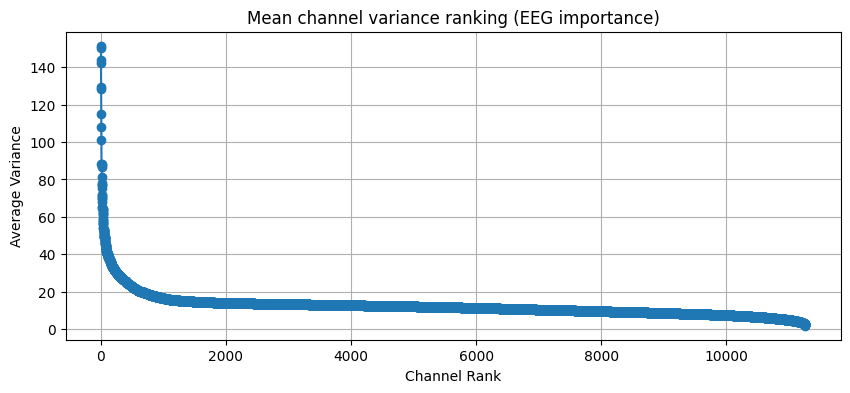

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sorted_vars = [v for _, v in sorted_channels]
plt.plot(sorted_vars, marker='o')
plt.title("Mean channel variance ranking (EEG importance)")
plt.xlabel("Channel Rank")
plt.ylabel("Average Variance")
plt.grid(True)
plt.show()


In [6]:
import numpy as np

shapes = []
for i, row in df.iloc[:50].iterrows():
    eeg = np.array(row.eeg_raw, dtype=np.float32)
    shapes.append(eeg.shape)

print("Unique EEG shapes found:", set(shapes))


Unique EEG shapes found: {(4033, 105), (5285, 105), (2598, 105), (3049, 105), (2325, 105), (3018, 105), (3062, 105), (6773, 105), (2558, 105), (2569, 105), (5646, 105), (5133, 105), (5014, 105), (3865, 105), (3779, 105), (3033, 105), (2593, 105), (3669, 105), (8564, 105), (2901, 105), (2421, 105), (2454, 105), (8896, 105), (3442, 105), (2469, 105), (8220, 105), (7289, 105), (5874, 105), (5984, 105), (3103, 105), (2126, 105), (4223, 105), (2643, 105), (3928, 105), (2634, 105), (2616, 105), (4760, 105), (3173, 105), (3822, 105), (4205, 105), (3833, 105), (4141, 105), (2706, 105), (2541, 105), (3309, 105), (2838, 105), (3113, 105), (1764, 105), (4381, 105), (5215, 105)}


In [7]:
import numpy as np

def fix_eeg_orientation(eeg):
    eeg = np.array(eeg, dtype=np.float32)
    if eeg.shape[1] != 105:
        eeg = eeg.T
    return eeg


In [8]:
from tqdm import tqdm
import numpy as np

def fix_eeg_orientation(eeg):
    eeg = np.array(eeg, dtype=np.float32)
    if eeg.ndim != 2:
        return None
    if eeg.shape[1] != 105:
        eeg = eeg.T
    return eeg

channel_vars = []
for i, row in tqdm(df.iloc[:800].iterrows(), total=min(800, len(df))):
    eeg = fix_eeg_orientation(row.eeg_raw)
    if eeg is None or eeg.shape[1] != 105:
        continue
    channel_vars.append(eeg.var(axis=0))

print(f"✅ Collected {len(channel_vars)} valid EEG samples.")


100%|██████████| 800/800 [00:00<00:00, 2903.99it/s]

✅ Collected 647 valid EEG samples.


In [9]:
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm

pca = PCA(n_components=24)  

processed_eeg = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    eeg = fix_eeg_orientation(row.eeg_raw)
    if eeg is None or eeg.ndim != 2:
        continue

    if eeg.shape[1] < 5:
        continue

    eeg = (eeg - eeg.mean(axis=0)) / (eeg.std(axis=0) + 1e-6)
    
    compressed = pca.fit_transform(eeg)  
    processed_eeg.append(compressed)


100%|██████████| 2956/2956 [00:47<00:00, 61.83it/s] 


In [10]:
valid_indices = []
processed_eeg = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    eeg = fix_eeg_orientation(row.eeg_raw)
    if eeg is None or eeg.ndim != 2 or eeg.shape[1] < 5:
        continue
    eeg = (eeg - eeg.mean(axis=0)) / (eeg.std(axis=0) + 1e-6)
    compressed = pca.fit_transform(eeg)
    processed_eeg.append(compressed)
    valid_indices.append(idx)


df_valid = df.loc[valid_indices].reset_index(drop=True)
df_valid["eeg_pca"] = processed_eeg
print(df_valid.shape, "✅ EEG PCA column added!")


100%|██████████| 2956/2956 [00:54<00:00, 54.40it/s] 

(2662, 17) ✅ EEG PCA column added!


In [11]:
df_valid.head()

,sentence_index,sentence,mean_a1_diff_mean,mean_a2_diff_mean,mean_b1_diff_mean,mean_b2_diff_mean,mean_g1_diff_mean,mean_g2_diff_mean,mean_t1_diff_mean,mean_t2_diff_mean,n_fixations,mean_fix_duration,mean_pupilsize,eeg_raw,subject_id,condition,eeg_pca
0,0,"Henry Ford, with his son Edsel, founded the Fo...",0.026597,0.058826,0.066639,0.086306,0.047350,0.152080,0.155088,0.057405,22.0,136.181818,3164.909091,"[[0.04213374758716981, -0.5965079873535998, -0...",YAC,NR,"[[6.268352, 3.3663254, -3.1877375, -2.3577592,..."
1,1,"After this initial success, Ford left Edison I...",-0.004890,0.025099,0.036040,0.128366,0.080538,0.174976,0.087336,0.068776,34.0,100.382353,3159.588235,"[[-0.30240420718598404, 2.473454223854762, 0.7...",YAC,NR,"[[-21.279352, -7.277079, 10.363797, 0.79163545..."
2,2,"With his interest in race cars, he formed a se...",0.003627,0.038220,0.027435,0.047429,0.063048,0.110071,0.012750,0.017143,17.0,133.647059,2905.117647,"[[0.012137721778602284, 0.09052314069747013, 0...",YAC,NR,"[[-1.6140128, -2.1801002, -4.4890532, -0.39533..."
3,3,"During this period, he personally drove his Qu...",0.070933,0.028654,0.047883,0.062360,0.034600,0.123079,0.130715,0.154881,35.0,120.228571,2972.285714,"[[-0.49631934269141675, 1.235886643666224, 0.0...",YAC,NR,"[[-19.38005, -10.465288, 1.1662059, 0.7231835,..."
4,4,Ford was forced out of the company by the inve...,-0.016555,0.003936,0.015857,0.062936,0.054237,0.174903,0.122884,0.083583,26.0,140.384615,2762.961538,"[[-0.4828231257567009, -0.45618668029047826, -...",YAC,NR,"[[-0.43343735, -7.8177624, 1.5806949, 0.549467..."


In [12]:

from scipy.signal import resample
TARGET_LEN = 256   

def resample_to_target(arr, target_len=TARGET_LEN):
    arr = np.asarray(arr, dtype=np.float32)
    if arr.shape[0] < 4:
        return None
    return resample(arr, target_len, axis=0)  # (TARGET_LEN, 24)

eeg_fixed = []
orig_lens = []
for arr in tqdm(df_valid['eeg_pca'].values):
    r = resample_to_target(arr, TARGET_LEN)
    if r is None:
        eeg_fixed.append(None)
        orig_lens.append(0)
    else:
        eeg_fixed.append(r)            # time x 24
        orig_lens.append(arr.shape[0])

df_valid['eeg_pca_res'] = eeg_fixed
df_valid['orig_len'] = orig_lens
df_valid = df_valid[df_valid['eeg_pca_res'].notnull()].reset_index(drop=True)
print("After resampling, samples:", len(df_valid))


100%|██████████| 2662/2662 [00:01<00:00, 2372.44it/s]

After resampling, samples: 2662


In [13]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sentence_index     2662 non-null   int64  
 1   sentence           2662 non-null   object 
 2   mean_a1_diff_mean  2662 non-null   float64
 3   mean_a2_diff_mean  2662 non-null   float64
 4   mean_b1_diff_mean  2662 non-null   float64
 5   mean_b2_diff_mean  2662 non-null   float64
 6   mean_g1_diff_mean  2662 non-null   float64
 7   mean_g2_diff_mean  2662 non-null   float64
 8   mean_t1_diff_mean  2662 non-null   float64
 9   mean_t2_diff_mean  2662 non-null   float64
 10  n_fixations        2662 non-null   float64
 11  mean_fix_duration  2662 non-null   float64
 12  mean_pupilsize     2662 non-null   float64
 13  eeg_raw            2662 non-null   object 
 14  subject_id         2662 non-null   object 
 15  condition          2662 non-null   object 
 16  eeg_pca            2662 

In [14]:
df_valid=df_valid.drop(columns=['eeg_raw','eeg_pca','orig_len','sentence_index','subject_id'])

In [15]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sentence           2662 non-null   object 
 1   mean_a1_diff_mean  2662 non-null   float64
 2   mean_a2_diff_mean  2662 non-null   float64
 3   mean_b1_diff_mean  2662 non-null   float64
 4   mean_b2_diff_mean  2662 non-null   float64
 5   mean_g1_diff_mean  2662 non-null   float64
 6   mean_g2_diff_mean  2662 non-null   float64
 7   mean_t1_diff_mean  2662 non-null   float64
 8   mean_t2_diff_mean  2662 non-null   float64
 9   n_fixations        2662 non-null   float64
 10  mean_fix_duration  2662 non-null   float64
 11  mean_pupilsize     2662 non-null   float64
 12  condition          2662 non-null   object 
 13  eeg_pca_res        2662 non-null   object 
dtypes: float64(11), object(3)
memory usage: 291.3+ KB


In [16]:
from sklearn.preprocessing import StandardScaler
import numpy as np

all_eeg = np.concatenate([np.array(x) for x in df_valid['eeg_pca_res']], axis=0)  
scaler_eeg = StandardScaler().fit(all_eeg)

df_valid['eeg_pca_res'] = df_valid['eeg_pca_res'].apply(lambda x: scaler_eeg.transform(np.array(x)))


In [17]:
from sklearn.preprocessing import StandardScaler

eye_cols = ['n_fixations', 'mean_fix_duration', 'mean_pupilsize']
scaler_eye = StandardScaler()
df_valid[eye_cols] = scaler_eye.fit_transform(df_valid[eye_cols])

In [18]:
spec_cols = [
    'mean_a1_diff_mean', 'mean_a2_diff_mean', 
    'mean_b1_diff_mean', 'mean_b2_diff_mean',
    'mean_g1_diff_mean', 'mean_g2_diff_mean',
    'mean_t1_diff_mean', 'mean_t2_diff_mean'
]
scaler_spec = StandardScaler()
df_valid[spec_cols] = scaler_spec.fit_transform(df_valid[spec_cols])

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_valid['condition_enc'] = le.fit_transform(df_valid['condition'])

In [20]:
df_valid=df_valid.drop(columns=['condition'])

In [21]:
df_valid.head()

,sentence,mean_a1_diff_mean,mean_a2_diff_mean,mean_b1_diff_mean,mean_b2_diff_mean,mean_g1_diff_mean,mean_g2_diff_mean,mean_t1_diff_mean,mean_t2_diff_mean,n_fixations,mean_fix_duration,mean_pupilsize,eeg_pca_res,condition_enc
0,"Henry Ford, with his son Edsel, founded the Fo...",-0.167585,-0.086344,0.131590,0.003545,-0.143840,-0.164476,0.277098,0.008671,0.659061,0.520424,0.760560,"[[0.029019233, 0.18597844, -0.2509601, -0.6129...",0
1,"After this initial success, Ford left Edison I...",-0.254211,-0.190352,0.016263,0.183641,0.043295,-0.123265,0.072781,0.042976,1.939583,-0.328972,0.750393,"[[0.2148783, -1.5076089, -0.16026255, -0.58289...",0
2,"With his interest in race cars, he formed a se...",-0.230782,-0.149889,-0.016166,-0.162924,-0.055326,-0.240090,-0.152144,-0.112784,0.125511,0.460283,0.264171,"[[0.14211667, -0.8252363, -0.6467773, -0.73789...",0
3,"During this period, he personally drove his Qu...",-0.045605,-0.179389,0.060903,-0.098989,-0.215730,-0.216676,0.203596,0.302726,2.046293,0.141909,0.392510,"[[-1.4829534, 0.20983215, -0.08060149, -0.5614...",0
4,Ford was forced out of the company by the inve...,-0.286307,-0.255612,-0.059806,-0.096525,-0.105006,-0.123398,0.179982,0.087643,1.085902,0.620142,-0.007450,"[[-0.4907018, -0.5717281, 1.3023124, 0.3279847...",0


In [22]:

shapes = {np.array(x).shape for x in df_valid["eeg_pca_res"]}
print(f"Unique EEG shapes found: {shapes}")
if len(shapes) == 1:
    print("✅ All EEG samples are fixed-length. You can train directly without padding.")
else:
    print("⚠️ Variable-length EEG sequences detected. Use a collate_fn with padding before training.")


Unique EEG shapes found: {(256, 24)}
✅ All EEG samples are fixed-length. You can train directly without padding.


In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
MAX_LEN = 64  

class MultimodalEEGDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)  
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        
        eeg_data = row['eeg_pca_res']
        if isinstance(eeg_data, (list, np.ndarray)):
            eeg = torch.tensor(np.array(eeg_data, dtype=np.float32), dtype=torch.float32)
        else:
            raise ValueError(f"Unexpected eeg_pca_res type: {type(eeg_data)}")
        
        
        eye = torch.tensor(
            row[['n_fixations', 'mean_fix_duration', 'mean_pupilsize']].values.astype(np.float32), 
            dtype=torch.float32
        )
        
        
        spec = torch.tensor(
            row[['mean_a1_diff_mean', 'mean_a2_diff_mean', 'mean_b1_diff_mean',
                 'mean_b2_diff_mean', 'mean_g1_diff_mean', 'mean_g2_diff_mean',
                 'mean_t1_diff_mean', 'mean_t2_diff_mean']].values.astype(np.float32), 
            dtype=torch.float32
        )
        
        text = str(row['sentence']) 
        
        
        encoded = tokenizer(
            text, 
            padding='max_length', 
            truncation=True, 
            max_length=MAX_LEN, 
            return_tensors='pt'
        )
        
        return {
        "eeg": eeg,
        "eye": eye,
        "spec": spec,
        "input_ids": encoded["input_ids"].squeeze(0),
        "attention_mask": encoded["attention_mask"].squeeze(0),
        "sentence": row["sentence"]          
    }



from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df_valid, test_size=0.15, random_state=42)

train_data = MultimodalEEGDataset(train_df)
val_data = MultimodalEEGDataset(val_df)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False, num_workers=0)

sample = next(iter(train_loader))
print("EEG shape:", sample["eeg"].shape)
print("Eye shape:", sample["eye"].shape)
print("Spec shape:", sample["spec"].shape)
print("Input IDs shape:", sample["input_ids"].shape)
print("Attention mask shape:", sample["attention_mask"].shape)

EEG shape: torch.Size([8, 256, 24])
Eye shape: torch.Size([8, 3])
Spec shape: torch.Size([8, 8])
Input IDs shape: torch.Size([8, 64])
Attention mask shape: torch.Size([8, 64])


In [24]:
df_valid[['n_fixations', 'mean_fix_duration', 'mean_pupilsize']].dtypes


n_fixations          float64
mean_fix_duration    float64
mean_pupilsize       float64
dtype: object

In [25]:
df_valid[['condition_enc']].dtypes


condition_enc    int64
dtype: object

In [26]:
df_valid[[
    'mean_a1_diff_mean','mean_a2_diff_mean','mean_b1_diff_mean','mean_b2_diff_mean',
    'mean_g1_diff_mean','mean_g2_diff_mean','mean_t1_diff_mean','mean_t2_diff_mean'
]].dtypes

mean_a1_diff_mean    float64
mean_a2_diff_mean    float64
mean_b1_diff_mean    float64
mean_b2_diff_mean    float64
mean_g1_diff_mean    float64
mean_g2_diff_mean    float64
mean_t1_diff_mean    float64
mean_t2_diff_mean    float64
dtype: object

In [27]:

batch = next(iter(train_loader))
input_ids = batch["input_ids"]
print("Min token:", input_ids.min().item())
print("Max token:", input_ids.max().item())
print("Tokenizer vocab size:", tokenizer.vocab_size)


Min token: 0
Max token: 28220
Tokenizer vocab size: 30522


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerDecoder, TransformerDecoderLayer
import random


class EEGEncoder(nn.Module):
    def __init__(self, input_dim=24, hidden_dim=128, out_dim=256):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(128, hidden_dim, batch_first=True, bidirectional=True)
        self.proj = nn.Linear(hidden_dim * 2, out_dim)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.proj(x)
        return x 

class EyeEncoder(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, hidden_dim)
        )

    def forward(self, x):
        return self.fc(x)  



class SpectralEncoder(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, hidden_dim)
        )

    def forward(self, x):
        return self.fc(x)  



class EEG2TextTransformer(nn.Module):
    def __init__(self, vocab_size, hidden_dim=384, n_heads=6, n_layers=3, max_len=64):
        super().__init__()

        
        self.eeg_enc = EEGEncoder()
        self.eye_enc = EyeEncoder()
        self.spec_enc = SpectralEncoder()
        self.hidden_dim = hidden_dim

        
        self.eeg_proj = nn.Linear(256, hidden_dim)
        self.eye_proj = nn.Linear(64, hidden_dim)
        self.spec_proj = nn.Linear(64, hidden_dim)

        
        self.token_emb = nn.Embedding(vocab_size, hidden_dim)
        self.pos_emb = nn.Embedding(max_len, hidden_dim)

        
        layer = TransformerDecoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            dim_feedforward=1024,
            dropout=0.3,
            batch_first=True
        )
        self.decoder = TransformerDecoder(layer, num_layers=n_layers)
        self.output_head = nn.Linear(hidden_dim, vocab_size)

    
    def forward(self, eeg, eye, spec, tgt_ids):
        B, seq_len = eeg.size(0), tgt_ids.size(1)
        device = eeg.device

    
        eeg_seq = self.eeg_enc(eeg)              
        eye_vec = self.eye_enc(eye)              
        spec_vec = self.spec_enc(spec)           

        
        eeg_memory = self.eeg_proj(eeg_seq)      
        eye_memory = self.eye_proj(eye_vec).unsqueeze(1)   
        spec_memory = self.spec_proj(spec_vec).unsqueeze(1)

        
        memory = torch.cat([eeg_memory, eye_memory, spec_memory], dim=1) 

        
        positions = torch.arange(seq_len, device=device).unsqueeze(0)
        tgt_emb = self.token_emb(tgt_ids) + self.pos_emb(positions)

        
        causal_mask = torch.triu(
            torch.ones(seq_len, seq_len, device=device, dtype=torch.bool), diagonal=1
        )

        out = self.decoder(tgt=tgt_emb, memory=memory, tgt_mask=causal_mask)
        logits = self.output_head(out)
        return logits  

    
    def top_k_top_p_filtering(self, logits, top_k=20, top_p=0.9):
   
        top_k = min(top_k, logits.size(-1))
    
        if top_k > 0:
        
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            logits[indices_to_remove] = -float('inf')
    
        if top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
        
        
            sorted_indices_to_remove = cumulative_probs > top_p
    
        if top_k > 0:
            sorted_indices_to_remove[..., :top_k] = False
        
        
            indices_to_remove = sorted_indices_to_remove.scatter(
                dim=-1, 
                index=sorted_indices, 
                src=sorted_indices_to_remove
            )
            logits[indices_to_remove] = -float('inf')
    
        return logits

    
    @torch.no_grad()
    def generate(self, eeg, eye, spec, tokenizer, max_len=50):
        device = next(self.parameters()).device
        B = eeg.size(0)
        generated = torch.full((B, 1), tokenizer.cls_token_id, device=device, dtype=torch.long)

        for _ in range(max_len):
            logits = self.forward(eeg, eye, spec, generated)
            next_token_logits = logits[:, -1, :] / 1.1   
            filtered_logits = self.top_k_top_p_filtering(next_token_logits, top_k=30, top_p=0.9)
            probs = F.softmax(filtered_logits, dim=-1)

            next_token = torch.multinomial(probs, num_samples=1)
            generated = torch.cat([generated, next_token], dim=1)

    
            decoded = tokenizer.decode(generated[0], skip_special_tokens=True)
            if "." in decoded:
                decoded = decoded[:decoded.index(".") + 1]
                break

            if torch.all(next_token == tokenizer.sep_token_id):
                break

        return generated, decoded




In [29]:

from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = EEG2TextTransformer(
    vocab_size=tokenizer.vocab_size,
    hidden_dim=384,
    n_heads=6,
    n_layers=3,
    max_len=64
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")


sample = next(iter(train_loader))
eeg = sample["eeg"].to(device)
eye = sample["eye"].to(device)
spec = sample["spec"].to(device)
input_ids = sample["input_ids"].to(device)

print("\nInput shapes:")
print(f"  EEG: {eeg.shape}")
print(f"  Eye: {eye.shape}")
print(f"  Spec: {spec.shape}")
print(f"  Input IDs: {input_ids.shape}")


logits = model(eeg, eye, spec, input_ids)
print(f"\nOutput logits shape: {logits.shape}")  # Should be (8, 64, 30522)


generated, decoded = model.generate(eeg[:1], eye[:1], spec[:1], tokenizer, max_len=20)

print(f"\nGenerated shape: {generated.shape}")
print(f"Generated text: {decoded}")


Model parameters: 29.94M

Input shapes:
  EEG: torch.Size([8, 256, 24])
  Eye: torch.Size([8, 3])
  Spec: torch.Size([8, 8])
  Input IDs: torch.Size([8, 64])

Output logits shape: torch.Size([8, 64, 30522])

Generated shape: torch.Size([1, 21])
Generated text: lawyers [unused231] lost drift halt livery介 clicking [unused723] gold ltª wizard wrestlers executeddi shed wizard 街 serum


In [30]:
from transformers import DistilBertTokenizer
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

vocab_size = tokenizer.vocab_size
model = EEG2TextTransformer(vocab_size).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

criterion = nn.CrossEntropyLoss(
    ignore_index=tokenizer.pad_token_id,
    label_smoothing=0.1
)


🧩 Epoch 1/30 | Train Loss: 7.7527, Val Loss: 5.9560, Train Acc: 0.251, Val Acc: 0.385
🧩 Epoch 2/30 | Train Loss: 5.5371, Val Loss: 5.0769, Train Acc: 0.433, Val Acc: 0.469
🧩 Epoch 3/30 | Train Loss: 4.8558, Val Loss: 4.5800, Train Acc: 0.496, Val Acc: 0.531
🧩 Epoch 4/30 | Train Loss: 4.4053, Val Loss: 4.1735, Train Acc: 0.560, Val Acc: 0.598
🧩 Epoch 5/30 | Train Loss: 4.0268, Val Loss: 3.8315, Train Acc: 0.622, Val Acc: 0.654
🧩 Epoch 6/30 | Train Loss: 3.7081, Val Loss: 3.5363, Train Acc: 0.677, Val Acc: 0.710
🧩 Epoch 7/30 | Train Loss: 3.4277, Val Loss: 3.2957, Train Acc: 0.730, Val Acc: 0.754
🧩 Epoch 8/30 | Train Loss: 3.1901, Val Loss: 3.0829, Train Acc: 0.777, Val Acc: 0.790
🧩 Epoch 9/30 | Train Loss: 2.9737, Val Loss: 2.9001, Train Acc: 0.820, Val Acc: 0.819
🧩 Epoch 10/30 | Train Loss: 2.7857, Val Loss: 2.7373, Train Acc: 0.857, Val Acc: 0.851
🧩 Epoch 11/30 | Train Loss: 2.6195, Val Loss: 2.5931, Train Acc: 0.891, Val Acc: 0.880
🧩 Epoch 12/30 | Train Loss: 2.4759, Val Loss: 2.4685

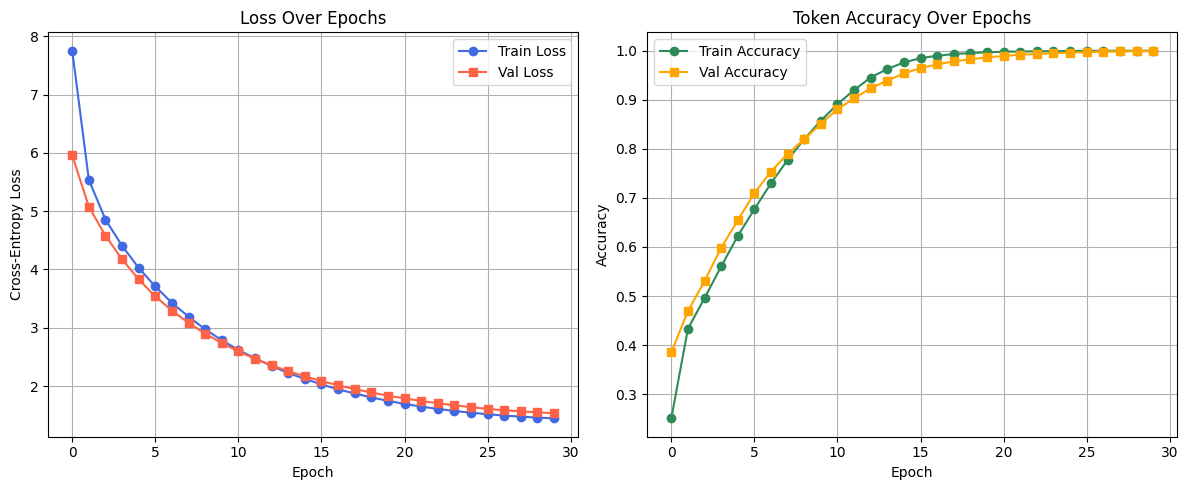

In [31]:
import matplotlib.pyplot as plt
import torch


train_losses, val_losses = [], []
train_accs, val_accs = [], []

EPOCHS = 30

def token_accuracy(logits, targets, pad_id):
    preds = torch.argmax(logits, dim=-1)
    mask = targets != pad_id
    correct = (preds[mask] == targets[mask]).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0.0

for epoch in range(EPOCHS):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    for batch in train_loader:
        eeg = batch["eeg"].to(device)
        eye = batch["eye"].to(device)
        spec = batch["spec"].to(device)
        input_ids = batch["input_ids"].to(device)

        optimizer.zero_grad()
        logits = model(eeg, eye, spec, input_ids)
        loss = criterion(logits.view(-1, logits.size(-1)), input_ids.view(-1))
        loss.backward()
        optimizer.step()

        acc = token_accuracy(logits, input_ids, tokenizer.pad_token_id)
        total_loss += loss.item()
        total_acc += acc

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for batch in val_loader:
            eeg = batch["eeg"].to(device)
            eye = batch["eye"].to(device)
            spec = batch["spec"].to(device)
            input_ids = batch["input_ids"].to(device)

            logits = model(eeg, eye, spec, input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), input_ids.view(-1))

            acc = token_accuracy(logits, input_ids, tokenizer.pad_token_id)
            val_loss += loss.item()
            val_acc += acc

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    print(f"🧩 Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Train Acc: {avg_train_acc:.3f}, Val Acc: {avg_val_acc:.3f}")


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', color='royalblue', marker='o')
plt.plot(val_losses, label='Val Loss', color='tomato', marker='s')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy', color='seagreen', marker='o')
plt.plot(val_accs, label='Val Accuracy', color='orange', marker='s')
plt.title("Token Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [32]:

torch.save(model.state_dict(), "best_model.pt")
print("✅ Model saved as best_model.pt")

✅ Model saved as best_model.pt


In [33]:
import numpy as np

for i, batch in enumerate(val_loader):
    eeg = batch["eeg"][0].cpu().numpy()
    eye = batch["eye"][0].cpu().numpy()
    spec = batch["spec"][0].cpu().numpy()
    sentence = batch["sentence"][0]
    np.savez(f"sample_{i+1}.npz", eeg=eeg, eye=eye, spec=spec, sentence=sentence)
    if i == 4:  
        break

print("✅ Saved 5 test samples: sample_1.npz ... sample_5.npz")


✅ Saved 5 test samples: sample_1.npz ... sample_5.npz


In [34]:
model.eval()
with torch.no_grad():
    batch = next(iter(val_loader))
    eeg, eye, spec = batch["eeg"].to(device), batch["eye"].to(device), batch["spec"].to(device)
    input_ids = batch["input_ids"].to(device)
    logits = model(eeg, eye, spec, input_ids)
    preds = torch.argmax(logits, dim=-1)

    for i in range(min(5, preds.size(0))):  
        decoded = tokenizer.decode(preds[i], skip_special_tokens=True)

        # stop after first period
        if "." in decoded:
            decoded = decoded[: decoded.index(".") + 1]

        print(f"🧠 Generated [{i}]:", decoded)
        print(f"💬 Ground truth [{i}]:", batch["sentence"][i])
        print("-" * 80)

🧠 Generated [0]: he had been educated at oxford and his closest friends and outlook on life were british.
💬 Ground truth [0]: He had been educated at Oxford and his closest friends and outlook on life were British.
--------------------------------------------------------------------------------
🧠 Generated [1]: in 1962, clampett created an animated version of the show called beany and cecil, which ran on abc for five years.
💬 Ground truth [1]: In 1962, Clampett created an animated version of the show called Beany and Cecil, which ran on ABC for five years.
--------------------------------------------------------------------------------
🧠 Generated [2]: while a printing apprentice he wrote under the pseudonym of'silence dogood'who was ostensibly a middle - aged widow.
💬 Ground truth [2]: While a printing apprentice he wrote under the pseudonym of 'Silence Dogood' who was ostensibly a middle-aged widow.
--------------------------------------------------------------------------------
🧠 Ge

In [36]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

refs, hyps = [], []
smooth = SmoothingFunction().method1  

model.eval()
with torch.no_grad():
    batch = next(iter(val_loader))
    eeg, eye, spec = batch["eeg"].to(device), batch["eye"].to(device), batch["spec"].to(device)
    input_ids = batch["input_ids"].to(device)

    logits = model(eeg, eye, spec, input_ids)
    preds = torch.argmax(logits, dim=-1)

    for i in range(min(5, preds.size(0))):  
        decoded = tokenizer.decode(preds[i], skip_special_tokens=True)
        if "." in decoded:
            decoded = decoded[: decoded.index(".") + 1]

        ref = batch["sentence"][i]
        

        
        refs.append([ref.lower().split()])
        hyps.append(decoded.lower().split())


bleu_scores = [sentence_bleu(ref, hyp, smoothing_function=smooth) for ref, hyp in zip(refs, hyps)]
avg_bleu = sum(bleu_scores) / len(bleu_scores)

print("📊 Sentence-level BLEU scores:", [round(s, 4) for s in bleu_scores])
print(f"⭐ Average BLEU score over {len(bleu_scores)} samples: {avg_bleu:.4f}")


📊 Sentence-level BLEU scores: [1.0, 1.0, 0.5399, 0.8001, 0.8137]
⭐ Average BLEU score over 5 samples: 0.8307
